<a href="https://colab.research.google.com/github/C1PO/Machine_learning/blob/main/cognition%26computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGNITION & COMPUTATION (A.Y. 2022-2023)

In this Python Notebook, I will use Convolutional Neural Networks (CNN) to classify cifar10 images.
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

This notebook is divided in some points:
1. In the first part I import the libraries I need and the cifar10 dataset.
2. I define the architecture of the CNN then I perform the training phase and I evaluate the model.
3. I perform linear readout at different level of the CNN
4. I plot the feature maps of different layers of the CNN
5. I evaluate the robustness of the model, by adding Gaussian noise and plot psychometric curves to see how the CNN responds to small changes in the input.
6. I evaluate the response to adversarial attacks using the Fast Gradient Sign Method (FGSM).
7. Finally, I train an autoencoder in order to reconstruct the original images from noisy input and I evaluate the CNN over these new images.

## Import the dataset and data normalization
In this section I import the CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
I divide the dataset in training (40000 samples) and validation (10000 samples), used for the training phase, and test set (10000 samples) used for the test phase.
Then, I normalize the image data so that each pixel has a value between 0 and 1 (important to improve model stability during training) and I convert the numeric label of each image into a one-hot encoding representation, i.e. a binary representation where each category is represented as a vector of 10 elements with all values ​​set to 0, except the one corresponding to the category which is 1.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from os import name
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, AveragePooling2D, Input, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
!pip install keract
from keract import get_activations, display_activations
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Splitting the dataset in trainig, validation and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
#ensuring that all image pixels are in range between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
x_val = x_val / 255.

In [4]:
# converting the labels to one-hot encoding format
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [5]:
print("Samples of the training set:", x_train.shape[0])
print("Samples of the validation set: ", x_val.shape[0])
print("Samples of the test set: ", x_test.shape[0])

Samples of the training set: 40000
Samples of the validation set:  10000
Samples of the test set:  10000


In [6]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

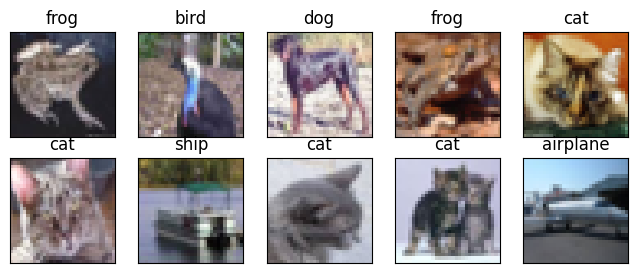

In [7]:
# plotting the first 10 images of the training set
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])
    ax.set_title(labels[np.argmax(y_train[i])])
plt.show()

## Define the model and training

In this section I define the Convolutional Neural Network used for the image classification. As we can see the network is composed by 3 blocks with:
* A convolutional layer with 32 filters of dimension 3x3.
* A BatchNormalization layer that is a layer used to normalize the input to each layer of a neural network, specifically to the output of the activation function.
* A convolutional layer with 32 filters of dimension 3x3.
* A BatchNormalization layer
* A maxPooling layer with a pool_size of 2x2: it divides the input data into non-overlapping 2x2 regions, and for each region, outputs the maximum value. This effectively downsamples the spatial dimensions of the input by a factor of 2.
* A Dropout layer: they randomly sets the 20% of the input units to zero. The purpose of the Dropout layer is to prevent overfitting in the network by reducing the dependence of the network.

Then the network has:
* a flatten layer that converts the output of the convolution in a one dimension vector.
* A Dropout layer
* A fully connected layer composed of 1024 neurons
* A Dropout layer
* And a fully connected layer composed of 10 neurons is used as output layer by the fact that there are 10 different classes in the dataset.

The network is compiled with a categorical cross-entropy loss function and an Adam optimizer with a learning rate of 0.001.
Finally, the model is evaluated on the test set using the evaluate function, and the test loss and accuracy are printed.
At the end of the section we can see the plot of the accuracy, the loss of the network and the consufion matrix.

In [8]:
#Define the architecture of the CNN

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], name='conv1'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', name='conv3'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', name='conv5'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv6'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu', name='dense1'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name='dense2'))

In [9]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In order to improve the performance of the network, I perform data augmentation on the training set using the ImageDataGenerator function of Keras. It includes rotating the images, shifting their width and height, and flipping them horizontally. Than, the augmented data is then used to train the model.

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(x_train)

Here I define two callbacks, that are functions called during the training process:
* Early stopping is an optimization technique used to reduce overfitting without compromising on model accuracy. Thus, it stops the training process if the validation loss does not improve for a certain number of consecutive epochs.
* ReduceLROnPlateau is a technique that dynamically adjusts the learning rate of a model during training. The main purpose of ReduceLROnPlateau is to help the model to converge faster and improve its performance.
It reduces the learning rate of the optimizer if the validation loss does not improve for a certain number of epochs.

In [11]:
# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0000001)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

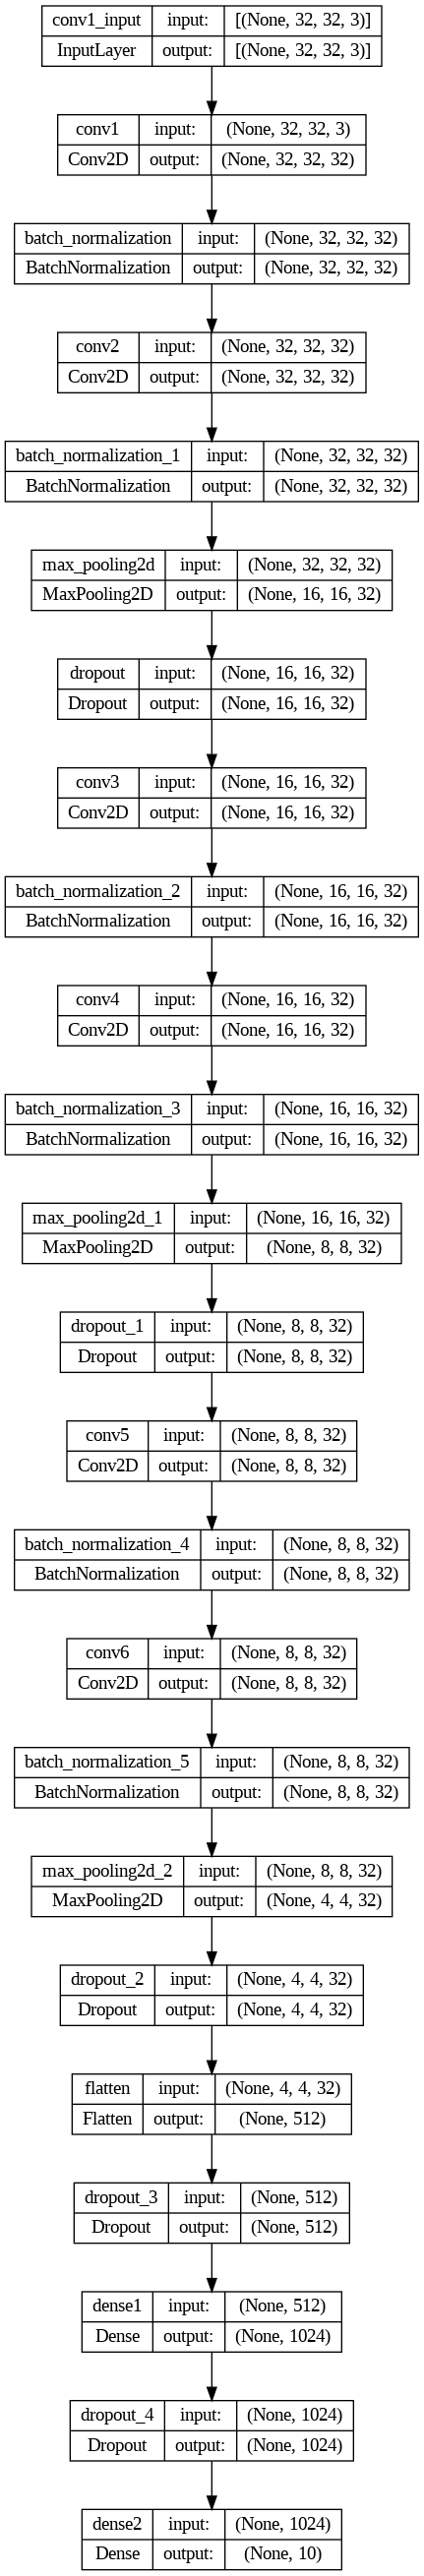

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
#Training the model using the validation set
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/30
625/625 [==============================] - 64s 64ms/step - loss: 1.6531 - accuracy: 0.4103 - val_loss: 1.3956 - val_accuracy: 0.4958 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 28s 45ms/step - loss: 1.3026 - accuracy: 0.5318 - val_loss: 1.3023 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 32s 51ms/step - loss: 1.1621 - accuracy: 0.5879 - val_loss: 1.3788 - val_accuracy: 0.5321 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 29s 46ms/step - loss: 1.0663 - accuracy: 0.6253 - val_loss: 1.0059 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 28s 45ms/step - loss: 1.0080 - accuracy: 0.6446 - val_loss: 0.9421 - val_accuracy: 0.6695 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 29s 46ms/step - loss: 0.9671 - accuracy: 0.6593 - val_loss: 0.9366 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 33s 

KeyboardInterrupt: ignored

In [ ]:
#Print the loss and accuracy
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
#Function that plots the accuracy of a history
def plot_accuracy(history):
  plt.figure(figsize=(8,5))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.show()

In [ ]:
#Function that plots the loss of a history
def plot_loss(history):
  plt.figure(figsize=(8,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

Let's now see the confusion matrix that shows us the number of correct and incorrect predictions for each class.

In [ ]:
#Confusion matrix
y_pred = model.predict(x_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_int, y_pred_int)

fig = ff.create_annotated_heatmap(z=np.array(cm), colorscale='Blues')
fig.update_layout(title='Confusion Matrix')
fig.show()

## Linear read out

By utilizing hidden representations and linear readouts, it becomes possible to inspect how the model processes and interprets the input data, and to evaluate its capacity to learn disentangled representations that are useful for making predictions. By analyzing the hidden representations at various levels of the neural network, we can determine if the model is able to learn progressively more independent and disentangled features in deeper layers, which may result in better performance. A disentangled representation refers to a type of feature representation where each feature or aspect of the input data is represented by a distinct and uncorrelated set of neurons. This makes it easier for the model to manipulate and reason about these features in a more understandable and efficient manner.
By performing the linear readout, we take the outputs of the three intermediate levels and feed them as input to the corresponding linear model.
Then I calculate the accuracy of these linear models.

In [ ]:
#Function that return the output of a given layer
def get_hidden_representation(dataset, layer_name):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(dataset)
    return intermediate_output

In [ ]:
#conv3_output_train = get_hidden_representation(x_train, 'conv3')
conv4_output_train = get_hidden_representation(x_train, 'conv4')
conv5_output_train = get_hidden_representation(x_train, 'conv5')
conv6_output_train = get_hidden_representation(x_train, 'conv6')

In [ ]:
input_shape = conv4_output_train.shape[1:]

# Creating the linear model with the correct input shape
linear_model2 = tf.keras.Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model
linear_model2.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the model
history_conv4 = linear_model2.fit(conv4_output_train,
                                 y_train,
                                 batch_size=64,
                                 epochs=20)

In [ ]:
input_shape = conv5_output_train.shape[1:]

# Creating the linear model with the correct input shape
linear_model3 = tf.keras.Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model
linear_model3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the model
history_conv5 = linear_model3.fit(conv5_output_train,
                                 y_train,
                                 batch_size=64,
                                 epochs=20)

In [ ]:
input_shape = conv6_output_train.shape[1:]

# Creating the linear model with the correct input shape
linear_model4 = tf.keras.Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model
linear_model4.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the model
history_conv6 = linear_model4.fit(conv6_output_train,
                                 y_train,
                                 batch_size=64,
                                 epochs=20)

In [ ]:
#Plot the loss of the convolutional layers
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(history_conv4.history['loss'], label='conv4 linear readout', linewidth=2)
ax.plot(history_conv5.history['loss'], label='conv5 linear readout', linewidth=2)
ax.plot(history_conv6.history['loss'], label='conv6 linear readout', linewidth=2)

ax.legend(loc='upper right', fontsize=12)

ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)

plt.show()

As we can see from the graph as we go deeper the loss decreases and the accuracy increases. This is because the model gradually learns to make correct classification as it descends in the deepest layer of the architecture.

In [ ]:
conv4_output_test = get_hidden_representation(x_test, 'conv4')
conv5_output_test = get_hidden_representation(x_test, 'conv5')
conv6_output_test = get_hidden_representation(x_test, 'conv6')

Let's now see the accuracy of the linear models just created:

In [ ]:
score_conv4 = linear_model2.evaluate(conv4_output_test, y_test, verbose=0)
print('Test accuracy of the linear model with the input equal to the output of the CNN conv4 layer:', score_conv4[1])

In [ ]:
score_conv5 = linear_model3.evaluate(conv5_output_test, y_test, verbose=0)
print('Test accuracy of the linear model with the input equal to the output of the CNN conv5 layer:', score_conv5[1])

In [ ]:
score_conv6 = linear_model4.evaluate(conv6_output_test, y_test, verbose=0)
print('Test accuracy of the linear model with the input equal to the output of the CNN conv6 layer:', score_conv6[1])

Based on the outcome mentioned above, a characteristic pattern can be observed in the linear output of a CNN. Specifically, the precision of each linear output improves progressively as one delves further into the underlying structure of the network. This indicates that as the CNN progresses through its convolutional layers, it extracts intricate and increasingly meaningful feature maps, enabling more precise categorization. Consequently, it can be inferred that the model effectively operates on the test data and has acquired the ability to generate reasonably precise forecasts.

## Features visualization

In this section I show the feature maps of the layers.
A feature map is an image produced as output by a single layer of a CNN.
It is created by applying a specific filter to the input image and highlights the areas of the image that the filter is designed to detect. Each feature map shows how the network processes the input and which regions of the image are important for classification. By looking at the feature maps, we can see how the network highlight different features of the image that are useful for classification.
In order to do this I use Keract that is a module which allows us to easily plot the feature maps of the various hidden layers.


In [ ]:
#First image of training
plt.imshow(x_train[0])
plt.show()

In [ ]:
layer_names=['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'dense1', 'dense2']

#get the activations of the first train sample
activations_cnn = get_activations(model, x_train[0:1], layer_names=layer_names)
# show the activations
display_activations(activations_cnn, cmap="viridis")

From the plotted feature maps of the first convolutional layer, we can see how the model highlight different features of the image, focusing on the deep of the lines or highlighting them in the 128 filters used in this layer.
Going deep in the feature map, the filters become less and less significant to the human eyes, since the dimension of the image is reduced, and it shows less and less recognizable details.

## Robustness to Gaussian noise

In this section I add Gaussian noise to the test set in order to see how the model reacts with random noise.
Adding Gaussian noise to images cause a reduction in image quality, with small variations in color or brightness that can distort the original image.

In [ ]:
print('Accuracy befor the noise: {:.2f}%'.format(test_acc * 100))

#Adding Gaussian noise
noise_factor = 0.1
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)


noise_loss, noise_acc = model.evaluate(x_test_noisy, y_test, verbose=0)
print('Accuracy after the noise: {:.2f}%'.format(noise_acc * 100))

Accuracy befor the noise: 79.27%
Accuracy after the noise: 20.73%


In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

313/313 [==============================] - 1s 3ms/step


As we can see adding Gaussian noise affect the image, making it less defined. With a noise parameter of 0.005 the prediction made by the model is still correct, but increasing the noise factor the same image will be misclassified. In fact the accuracy level strongly decreases as noise level increase and in the same way the loss increase for higher values of noise.
Below there is an example of a missclassified image.

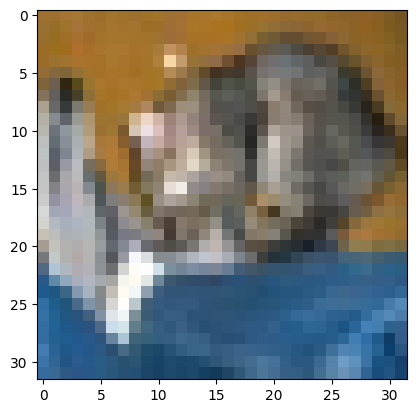

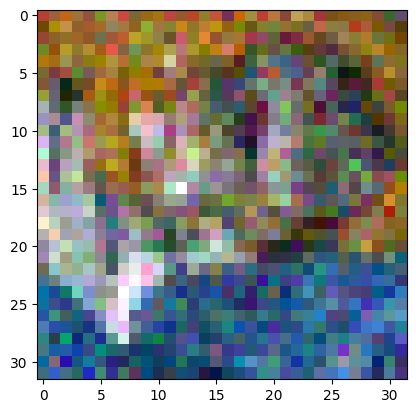

label originale cat
label dopo noise frog
label predetta dal modello originale frog


In [ ]:
plt.imshow(x_test[0])
plt.show()
plt.imshow(x_test_noisy[0],cmap = 'viridis',interpolation = "nearest")
plt.show()
print("True label", labels[np.argmax(y_test[0])])
print("Label predicted after the noise", labels[np.argmax(y_pred_noisy[0])])

## Adversarial Attack

An adversarial attack refers to a specialized input designed specifically for a Neural Network with the aim of causing misclassification by the model. In particular, we have implemented one of the most widely used techniques known as the white box Fast gradient sign method.
Essentially, FGSM computes the gradients of a loss function with respect to the input image and then uses the sign of the gradients to create a new image (i.e., the adversarial image). This approach is adopted because the goal is to generate an image that maximizes the loss. To achieve this, a technique is employed to determine the contribution of each pixel in the image to the overall loss value and introduce a perturbation accordingly.
The advantage of this method is its efficiency, as it is relatively straightforward to calculate the impact of each input pixel on the loss using the chain rule and obtaining the necessary gradients. Thus, the gradients are taken with respect to the image itself.
This is the formula of FGSM:

$adv_x = x + \epsilon \cdot \text{sign}(\nabla_{x} J(θ, x, y))$

where:
* $adv_x$ : Adversarial image.
* $x$ : Original input image.
* $y$ : Original input label.
* $\epsilon$ : Multiplier to ensure the perturbations are small.
* $\theta$ : Our neural network model
* $J$: The loss function

Considering the dataset's large size and the limited resources available on Google Colab, we made the decision not to execute the FGSM attack on the complete dataset. Instead, we opted to apply the attack to a subset of images while varying the values of epsilon. This strategy should adequately demonstrate the functionality of the FGSM and assess the resilience of the CNN we previously developed against such attacks.





In [ ]:
# Function that generate adversarial attack using the Fast Gradient Sign Method
def generate_adversarial_example(input_image, input_label, epsilon):

    input_image = tf.cast(input_image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)

    # Calculate the gradients w.r.t. input image
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    perturbation = epsilon * signed_grad

    # Perturbation of the original image
    perturbed_image = input_image + perturbation
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)

    return perturbed_image

In [ ]:
def plot_adversarial_image(x_adv):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(x.squeeze(), cmap='viridis')
  axs[0].set_title('Original Example')
  axs[1].imshow(x_adv.numpy().squeeze(), cmap='viridis')
  axs[1].set_title('Adversarial Example')
  plt.show()

  y_pred = model.predict(x)
  y_pred_adv = model.predict(x_adv)

  print('True Label:', labels[y_true])
  print('Predicted label after adversarial attack:', labels[np.argmax(y_pred_adv)])


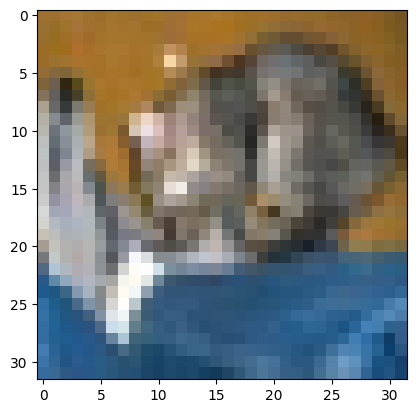

In [ ]:
plt.imshow(x_test[0])
plt.show()

Epsilon:  0.005


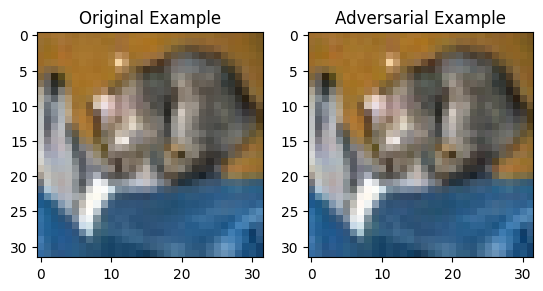

1/1 [==============================] - 0s 21ms/step
True Label: cat
Predicted label after adversarial attack: ship
Epsilon:  0.01


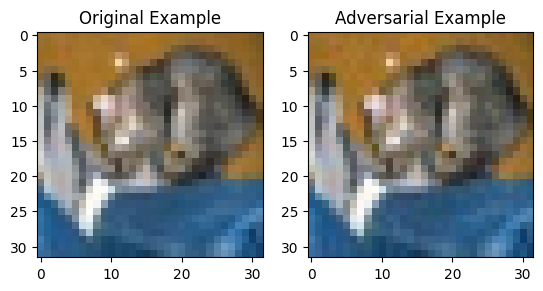

1/1 [==============================] - 0s 20ms/step
True Label: cat
Predicted label after adversarial attack: ship
Epsilon:  0.02


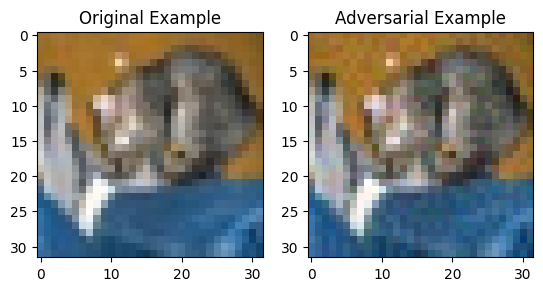

1/1 [==============================] - 0s 19ms/step
True Label: cat
Predicted label after adversarial attack: ship
Epsilon:  0.03


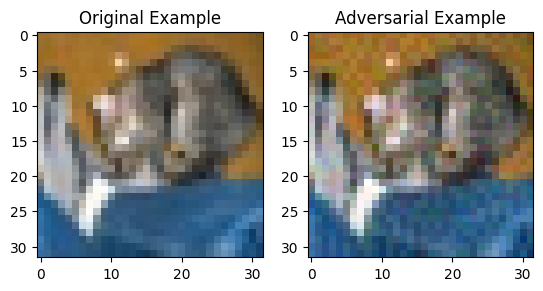

1/1 [==============================] - 0s 19ms/step
True Label: cat
Predicted label after adversarial attack: frog
Epsilon:  0.04


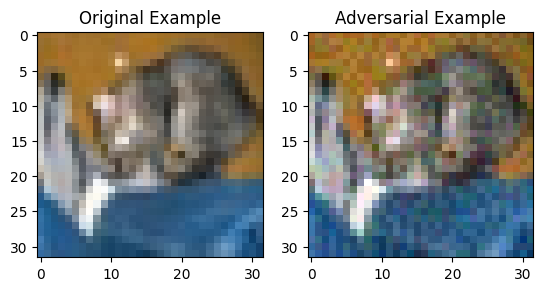

1/1 [==============================] - 0s 29ms/step
True Label: cat
Predicted label after adversarial attack: frog
Epsilon:  0.05


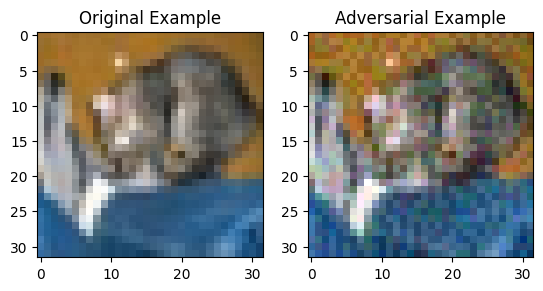

1/1 [==============================] - 0s 18ms/step
True Label: cat
Predicted label after adversarial attack: frog
Epsilon:  0.06


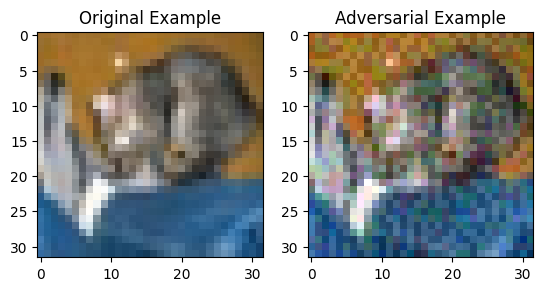

1/1 [==============================] - 0s 22ms/step
True Label: cat
Predicted label after adversarial attack: frog
Epsilon:  0.07


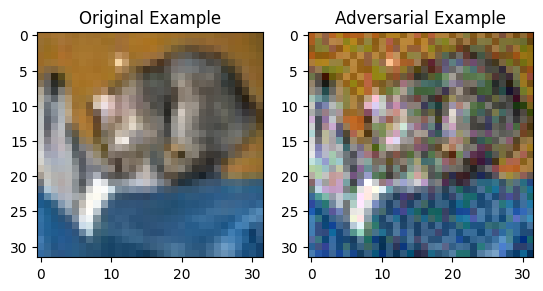

1/1 [==============================] - 0s 22ms/step
True Label: cat
Predicted label after adversarial attack: frog
Epsilon:  0.08


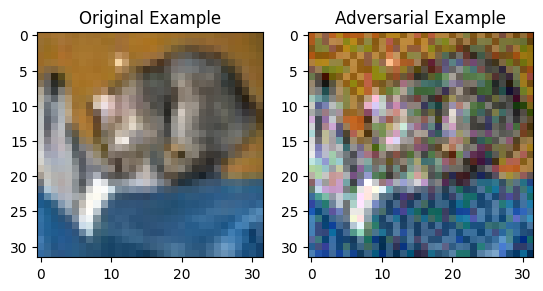

1/1 [==============================] - 0s 21ms/step
True Label: cat
Predicted label after adversarial attack: frog
Epsilon:  0.09


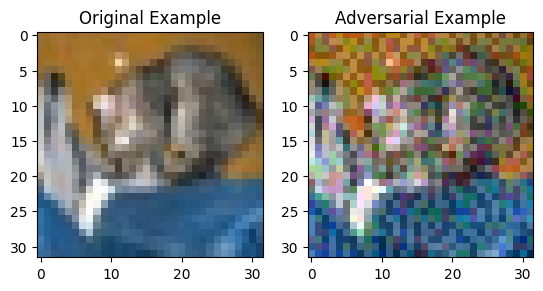

1/1 [==============================] - 0s 23ms/step
True Label: cat
Predicted label after adversarial attack: frog


In [ ]:
x = x_test[0]
x = x.reshape(1, 32, 32, 3)
y_true = np.argmax(y_test[0])
epsilons = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.07,0.08,0.09]

#show the image with several epsilon values
for i in epsilons:
  x_adv = generate_adversarial_example(x, y_true, i)
  print("Epsilon: ",i)
  plot_adversarial_image(x_adv)

## Convolutional Autoencoder

Now, a Convolutional Auto Encoder is established for the purpose of executing image denoising. Broadly speaking, an autoencoder is an unsupervised neural network employed to diminish the dimensionality of the input data by acquiring a compressed representation and subsequently reconstructing the initial data based on said compressed representation.

An autoencoder consists of two primary components:

* Encoder: Receives the original image and converts it into a compressed representation.
* Decoder: Takes the output from the encoder and reconstructs the original input utilizing the compressed representation.

CONTINUA DESCRIVENDO I LAYERS ECC...

In [ ]:
#Function to create an autoencoder
def create_model():
  input_image = tf.keras.Input(shape=(32, 32, 3))

  #Encoding phase
  x = Conv2D(32, 3, activation='relu', padding='same', name='encoder_first_conv')(input_image)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, 3, activation='relu', padding='same', name='encoder_second_conv')(x)
  encoded = MaxPooling2D(2, padding='same')(x)
  print(encoded.shape)

  #Decoding phase
  x = Conv2D(16, 3, activation='relu', padding='same',name='decoder_first_conv')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, 3, activation='relu', padding='same',name='decoder_second_conv')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='last_conv')(x)
  autoencoder = tf.keras.Model(input_image, decoded)
  autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
  return autoencoder

autoencoder_layer_names = ['encoder_first_conv','encoder_second_conv','decoder_first_conv','decoder_second_conv','last_conv']

In [ ]:
autoencoder = create_model()

(None, 8, 8, 16)


In [ ]:
noise_level = 0.3

#Insert noise in the training set
x_train_noisy = x_train + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

#Insert noise in the validation set
x_val_noisy = x_val + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

#Force the pixel value to be between 0 and 1
X_train_noisy = np.clip(x_train_noisy, 0., 1.)
X_validation_noisy = np.clip(x_val_noisy, 0., 1.)


In [ ]:
autoencoder_results=autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=False,
                validation_data=(x_val_noisy, x_val)
                )

Epoch 1/10
313/313 [==============================] - 8s 16ms/step - loss: 0.0952 - val_loss: 0.0790
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0759 - val_loss: 0.0740
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0722 - val_loss: 0.0711
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0705 - val_loss: 0.0697
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0693 - val_loss: 0.0687
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0684 - val_loss: 0.0681
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0678 - val_loss: 0.0674
Epoch 8/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0672 - val_loss: 0.0668
Epoch 9/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0667 - val_loss: 0.0663
Epoch 10/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0662 - val_loss

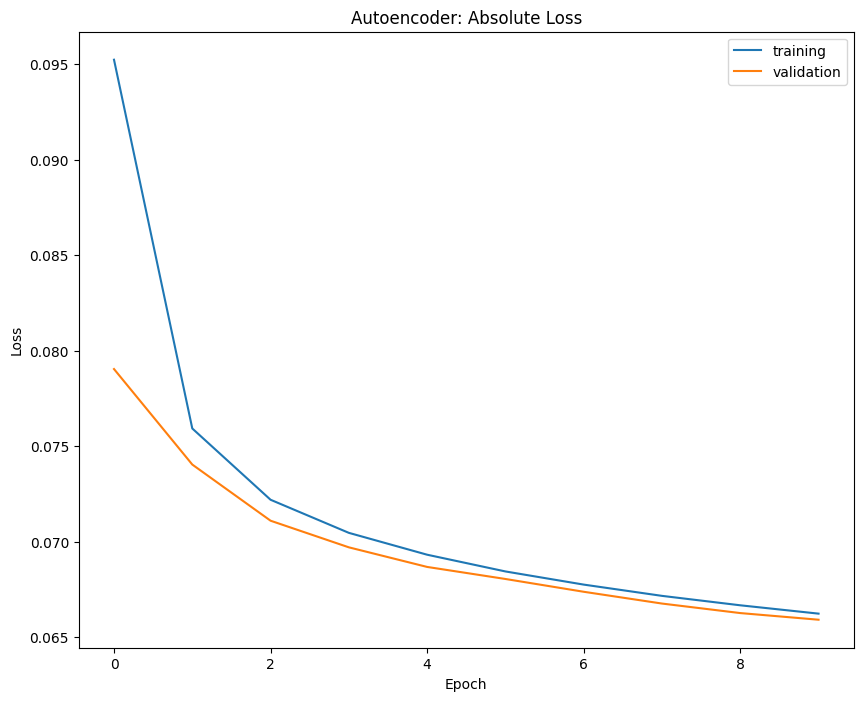

In [ ]:
 #Store the loss of the training and validation set
training_loss = autoencoder_results.history['loss']
validation_loss = autoencoder_results.history['val_loss']

#Loss history for training and validation
plt.figure(figsize=(10, 8))
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Autoencoder: Absolute Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

313/313 [==============================] - 1s 2ms/step


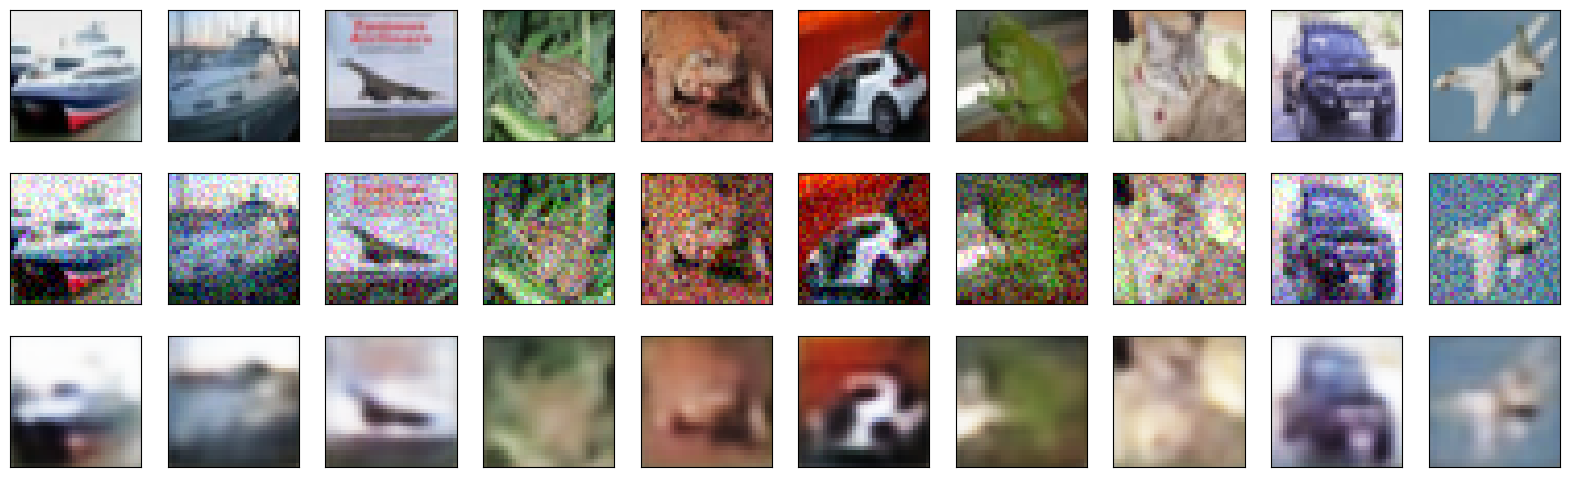

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(1, n + 1):
    # Display Original images
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display perturbed images
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + (2*n))
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
#get the activations of the first train sample
activations_cnn = get_activations(autoencoder, x_train[0:1], layer_names=layer_names)
# show the activations
display_activations(activations_cnn, cmap="viridis")

From the plotted features maps of the encoder, we cannot recognize any elements highlighted by the filters. The decoder only shows us some major details of the image that still remain too much blurred.

In [ ]:
#Make predictions on the decoded_images by the autoencoder
res_test=model.evaluate(decoded_imgs,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.7388 - accuracy: 0.3417
